In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df1 = pd.read_excel('csv/DSF1.xlsx')
df2 = pd.read_excel('csv/DSF2.xlsx')
df3 = pd.read_excel('csv/DSF3.xlsx')

col_list = ['id', 'IP', 'dt_completion', 't_used', 'mail', 'name']

for i, col in enumerate(df2.columns):
    if col not in col_list:
        df2.rename(columns={col: f'column_{i+1}'}, inplace=True)

for i, col in enumerate(df3.columns):
    if col not in col_list:
        df3.rename(columns={col: f'column_{i+1}'}, inplace=True)

merged_df = pd.merge(df2, df3, on=list(df2.columns) + list(df3.columns),  how='outer')

In [2]:
columns_to_delete = [col for col in merged_df.columns if col.startswith('column_') and int(col.split('_')[1]) % 3 != 0]

In [3]:
merged_df = merged_df.drop(columns=columns_to_delete, axis=1)

In [4]:
cols_to_process = merged_df.columns[6:]

merged_df[cols_to_process] = merged_df[cols_to_process].replace(regex={r'1 из 1': 1, '0 из 1': 0})
merged_df[cols_to_process] = merged_df[cols_to_process].fillna(0).astype(int)

df = merged_df.copy()

In [5]:
s_questions = [10, 9, 8, 9, 8, 8, 8, 9, 8, 8, 8, 4]

start_col = 6
end_col = start_col

for i, num_questions in enumerate(s_questions):
    end_col += num_questions
    section_num = i + 1
    section_name = 'S' + str(section_num)
    section_cols = list(range(start_col, end_col))
    df[str(section_name)] = df.iloc[:, section_cols].sum(axis=1)
    start_col = end_col

columns_to_del = [col for col in merged_df.columns if col.startswith('column_')]
df = df.drop(columns=columns_to_del, axis=1)

In [6]:
df = pd.merge(df, df1, on=list(df.columns) + list(df1.columns),  how='outer')
df['t_used'] = df['t_used'].astype(str)
df['t_used'] = pd.to_timedelta(df['t_used'])
df = df[df['t_used'] >= pd.Timedelta(minutes=5)]

In [7]:
df.sort_values('dt_completion', inplace=True)

df = df.groupby('IP').first().reset_index()

In [8]:
df = df.groupby('mail').first().reset_index()

In [9]:
df = df.groupby('name').first().reset_index()

In [10]:
df.index.name = 'index'

In [11]:
private = df.copy(['name', 'mail', 'IP', 'dt_completion', 't_used'])
df = df.drop(['id','name', 'mail', 'IP', 'dt_completion', 't_used'], axis=1)

In [12]:
df

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12
index,,,,,,,,,,,,
0,5,1,2,3,2,3,2,3,4,2,0,2
1,2,3,0,1,2,2,1,2,2,1,1,1
2,5,4,1,4,2,3,3,0,4,3,2,1
3,3,3,2,0,1,3,3,2,2,2,1,2
4,3,4,2,1,0,3,1,0,2,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
492,2,2,1,1,2,3,3,2,5,0,3,1
493,1,2,1,1,0,0,1,2,2,1,3,1
494,3,4,0,0,4,2,3,3,5,3,1,3


In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_answers = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
normalized_answers

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12
0,0.833333,0.2,0.4,0.6,0.4,0.6,0.4,0.6,0.8,0.4,0.0,0.50
1,0.333333,0.6,0.0,0.2,0.4,0.4,0.2,0.4,0.4,0.2,0.2,0.25
2,0.833333,0.8,0.2,0.8,0.4,0.6,0.6,0.0,0.8,0.6,0.4,0.25
3,0.500000,0.6,0.4,0.0,0.2,0.6,0.6,0.4,0.4,0.4,0.2,0.50
4,0.500000,0.8,0.4,0.2,0.0,0.6,0.2,0.0,0.4,0.6,0.2,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
492,0.333333,0.4,0.2,0.2,0.4,0.6,0.6,0.4,1.0,0.0,0.6,0.25
493,0.166667,0.4,0.2,0.2,0.0,0.0,0.2,0.4,0.4,0.2,0.6,0.25
494,0.500000,0.8,0.0,0.0,0.8,0.4,0.6,0.6,1.0,0.6,0.2,0.75
495,0.833333,1.0,0.2,1.0,1.0,0.6,0.8,0.8,1.0,0.8,0.4,0.50


In [14]:
mean = normalized_answers.mean()

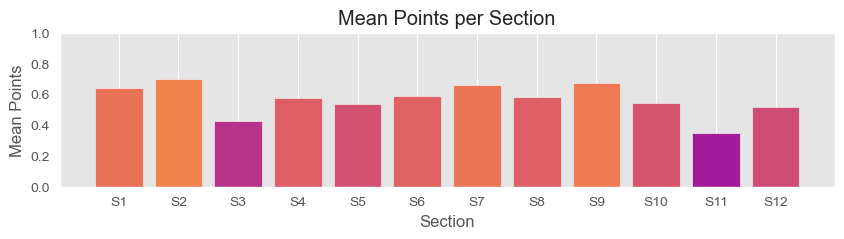

In [15]:
plt.style.use('ggplot')

plt.figure(figsize=(10, 2))
plt.bar(mean.index, mean.values, color=cm.plasma(mean.values))
plt.ylim(0, 1)
plt.xlabel('Section')
plt.ylabel('Mean Points')
plt.title('Mean Points per Section')
plt.grid(axis='y')
plt.savefig('mean.png', dpi=400)